In [40]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
data = pd.read_csv("/content/HousesInfo.csv")
data.head()

,x1,x2,x3,x4,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [14]:
Y = data["price"].values
print(Y.shape)

(535,)


In [ ]:
def combine_images(image_paths):
    images = [Image.open(img).resize((128, 128)) for img in image_paths]

    new_img = Image.new('RGB', (256, 256))

    new_img.paste(images[0], (0, 0))         # بالا چپ
    new_img.paste(images[1], (128, 0))       # بالا راست
    new_img.paste(images[2], (0, 128))       # پایین چپ
    new_img.paste(images[3], (128, 128))     # پایین راست
    new_img = new_img.resize((224, 224))
    return new_img


for i in range(1,536):
  folder = '/content/drive/MyDrive/Houses Dataset'
  house_id = i
  img_paths = [
      os.path.join(folder, f"{house_id}_bathroom.jpg"),
      os.path.join(folder, f"{house_id}_bedroom.jpg"),
      os.path.join(folder, f"{house_id}_frontal.jpg"),
      os.path.join(folder, f"{house_id}_kitchen.jpg"),
  ]

  combined = combine_images(img_paths)
  combined.save(f"/content/drive/MyDrive/Dataset/{house_id}_combined.jpg")


In [15]:
X = []

for image in os.listdir("/content/drive/MyDrive/Dataset"):
  img = cv2.imread("/content/drive/MyDrive/Dataset/" + image)
  X.append(img)

X = np.array(X)
print(X.shape)

(535, 224, 224, 3)


In [16]:
X_train , X_validation , Y_train , Y_validation = train_test_split(X,Y,test_size=0.2,random_state=42)
print(X_train.shape)
print(X_validation.shape)
print(Y_train.shape)
print(Y_validation.shape)

(428, 224, 224, 3)
(107, 224, 224, 3)
(428,)
(107,)


In [22]:
image_data_generator = ImageDataGenerator(
    rescale=1./255.0,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    rotation_range=15,
    zoom_range=0.1
)

dataset_train = image_data_generator.flow(X_train,Y_train,batch_size=8)
dataset_validation = image_data_generator.flow(X_validation,Y_validation,batch_size=8)

In [23]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=(224,224,3),include_top=False,weights='imagenet',pooling="avg")

In [26]:
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(1,activation="linear")
])

In [27]:
model.compile(optimizer="adam",loss="mae")

In [28]:
history = model.fit(dataset_train , epochs=12 , validation_data=dataset_validation, batch_size=8)

Epoch 1/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 120s 913ms/step - loss: 610395.8750 - val_loss: 551102.6875
Epoch 2/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 570777.8750 - val_loss: 549066.0000
Epoch 3/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - loss: 613158.5000 - val_loss: 546038.7500
Epoch 4/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - loss: 622296.1875 - val_loss: 544399.3125
Epoch 5/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 591824.3750 - val_loss: 540675.3125
Epoch 6/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - loss: 588492.0000 - val_loss: 531493.3125
Epoch 7/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - loss: 593823.8750 - val_loss: 523671.2188
Epoch 8/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - loss: 630906.0000 - val_loss: 512022.2500
Epoch 9/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - loss: 539632.6875 - val_loss: 494685.9062
Epoch 10/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - loss: 599236.6875 - val_loss: 500384.2188
Epoch 11/12
54/54 ━━━━━━━━━━━━━━━━

In [44]:
img1 = Image.open("/content/bathroom.jpg")
img2 = Image.open("/content/bedroom.jpg")
img3 = Image.open("/content/kitchen.jpg")
img4 = Image.open("/content/frontal.jpg")

img1 = img1.resize((224, 224))
img2 = img2.resize((224, 224))
img3 = img3.resize((224, 224))
img4 = img4.resize((224, 224))

final_img = Image.new('RGB', (224*2, 224*2))
final_img.paste(img1, (0, 0))
final_img.paste(img2, (224, 0))
final_img.paste(img3, (0, 224))
final_img.paste(img4, (224, 224))

final_img = final_img.resize((224, 224))

final_img = np.array(final_img) / 255.0
final_img = np.expand_dims(final_img, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
[[4339.4624]]


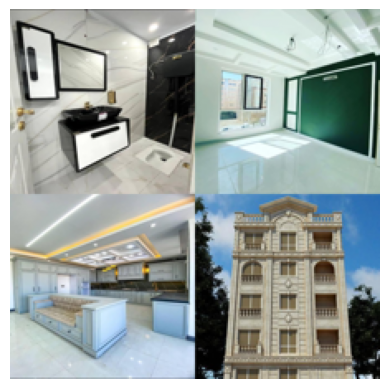

In [45]:
print(model.predict(final_img))
final_img = np.squeeze(final_img)
plt.imshow(final_img)
plt.axis('off')
plt.show()